# MultiStain-GAN Training on H100

Multi-Target Virtual Staining for Breast Cancer Histopathology

**Hardware:** NVIDIA H100 40GB  
**Dataset:** IHC4BC (~74K paired images)  
**Estimated Time:** 60-84 hours (300 epochs)

## 1. Setup Environment

In [1]:
import os
import sys

# Check if we need to fix numpy
try:
    import numpy
    version = numpy.__version__
    major_ver = int(version.split('.')[0])
    
    if major_ver >= 2:
        print(f"Detected NumPy {version}. Downgrading to <2.0...")
        !pip install "numpy<2.0" --quiet
        print("Downgrade complete. Restarting kernel...")
        # This kills the kernel to force a restart (works on Colab/Jupyter)
        os.kill(os.getpid(), 9)
    else:
        print(f"NumPy version {version} is compatible.")
        
except ImportError:
    !pip install "numpy<2.0" --quiet

NumPy version 1.26.4 is compatible.


In [2]:
# Verify GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0a0+df5bbc09d1.nv24.12
CUDA available: True
GPU: NVIDIA H100 80GB HBM3 MIG 3g.40gb
VRAM: 42.3 GB
CUDA version: 12.6


## 2. Upload Dataset

Upload your IHC4BC dataset to the server. Expected structure:
```
IHC4BC_Compressed/
├── Images/
│   ├── HandE/{ER,PR,Ki67,Her2}/Patient_X/Subregion_Y/*.jpg
│   └── IHC/{ER,PR,Ki67,Her2}/Patient_X/Subregion_Y/*.jpg
└── Labels/
```

In [ ]:
# Download IHC4BC from Kaggle (token-based auth)
import os

# Paste your NEW token here (do not share it)
os.environ["KAGGLE_API_TOKEN"] = "KGAT_245bb2fd7e1d794ff555c89bfd6d5d97"

# Install kaggle CLI if needed
import sys
!{sys.executable} -m pip -q install kaggle

# Download and unzip into ./data
!kaggle datasets download -d akbarnejad1991/ihc4bc-compressed -p ./data --unzip

In [ ]:
# Set your dataset path here
# Example Windows: "D:/IHC4BC_Compressed"
# Example Linux: "/workspace/IHC4BC_Compressed"
POSSIBLE_PATHS = [
    "D:/IHC4BC (IHC for Breast Cancer) - Compressed Dataset/archive (4)/IHC4BC_Compressed",
    "/workspace/Multitarget_virtual_staining__GAN/data/IHC4BC_Compressed",
    "/workspace/IHC4BC_Compressed",
    "C:/Users/shiva/OneDrive/Desktop/Multitarget_virtual_staining__GAN/data/IHC4BC_Compressed",
    "./data/IHC4BC_Compressed",
    "./IHC4BC_Compressed",
 ]

DATASET_PATH = None
for p in POSSIBLE_PATHS:
    if os.path.exists(p):
        DATASET_PATH = p
        break

if DATASET_PATH is None:
    DATASET_PATH = "<UPDATE_ME>"  # <-- UPDATE THIS!

# Verify dataset exists
if os.path.exists(DATASET_PATH):
    print(f"✓ Dataset found at: {DATASET_PATH}")
    print(f"  Contents: {os.listdir(DATASET_PATH)}")
    
    images_path = os.path.join(DATASET_PATH, 'Images')
    if os.path.exists(images_path):
        print(f"  Images folder: {os.listdir(images_path)}")
else:
    print(f"✗ Dataset not found at: {DATASET_PATH}")
    print("  Please update DATASET_PATH variable above")

✓ Dataset found at: /workspace/Multitarget_virtual_staining__GAN/data/IHC4BC_Compressed
  Contents: ['.ipynb_checkpoints', 'Images']
  Images folder: ['.ipynb_checkpoints', 'HandE']


In [ ]:
# Sanity check dataset structure and domain folders
from pathlib import Path

root = Path(DATASET_PATH)
print("Root exists:", root.exists(), "->", root)

images_dir = root / "Images"
hande_dir = images_dir / "HandE"
ihc_dir = images_dir / "IHC"
print("Images dir:", images_dir.exists())
print("HandE dir:", hande_dir.exists())
print("IHC dir:", ihc_dir.exists())

if hande_dir.exists():
    print("HandE domains:", [p.name for p in hande_dir.iterdir() if p.is_dir()])
if ihc_dir.exists():
    print("IHC domains:", [p.name for p in ihc_dir.iterdir() if p.is_dir()])

# Count a few files to confirm paths
def count_jpgs(folder: Path):
    return sum(1 for _ in folder.rglob("*.jpg")) if folder.exists() else 0

for domain in ['ER', 'PR', 'Ki67', 'Her2']:
    he_count = count_jpgs(hande_dir / domain)
    ihc_count = count_jpgs(ihc_dir / domain)
    print(f"{domain}: HandE={he_count}, IHC={ihc_count}")

In [ ]:
# Search for an IHC folder if the default is missing
from pathlib import Path

root = Path(DATASET_PATH)
candidates = []
for p in root.rglob('*'):
    if p.is_dir() and p.name.lower() == 'ihc':
        candidates.append(p)

if candidates:
    print("Found IHC folders:")
    for c in candidates:
        print(" -", c)
else:
    print("No IHC folder found under DATASET_PATH.")
    print("Update DATASET_PATH to the folder that contains Images/IHC.")

## 3. Configuration

In [ ]:
# H100-optimized configuration - STABLE v7 (FULL COLOR FIX)
CONFIG = {
    # Model - OPTIMIZED FOR COLOR DIVERSITY
    'model': {
        'image_size': 256,
        'latent_dim': 64,            # Increased from 16 -> 64 for more diversity
        'style_dim': 256,            # CRITICAL: Increased from 64 -> 256 (weak style = mode collapse)
        'num_domains': 4,
        'generator': {
            'enc_channels': [64, 128, 256, 512],
            'num_res_blocks': 6,
            'vit_blocks': 2,          # REDUCED from 4 -> 2 (ViT attention can collapse)
            'vit_heads': 8,
            'use_pretrained': True,
            'use_checkpoint': True,
        },
        'discriminator': {
            'num_scales': 3,          # INCREASED from 2 -> 3 for better multi-res color feedback
            'base_channels': 64,
            'num_layers': 4,          # INCREASED from 3 -> 4 for deeper color discrimination
            'use_spectral_norm': True,
        },
        'style_encoder': {
            'pretrained': True,
            'freeze_layers': 0,       # CRITICAL FIX: Unfreeze all layers to learn IHC colors
        },
        'mapping_network': {
            'num_layers': 6,
            'hidden_dim': 512,
        },
    },
    
    # Dataset
    'data': {
        'root_dir': DATASET_PATH,
        'domains': ['ER', 'PR', 'Ki67', 'Her2'],
        'num_workers': 8,
        'pin_memory': True,
        'paired_only': True,
        'paired_reference': True,
        'subset_fraction': 0.1,
        'balanced_sampling': True,
    },
    
    # Training - STABLE v7 (FULL COLOR FIX)
    'training': {
        'batch_size': 12,             # Reduced from 16 due to more D scales
        'accumulate_grad': 4,         # Increased to compensate for smaller batch
        'epochs': 100,
        'grad_clip_max_norm': 1.0,
        'adv_loss_type': 'hinge',
        'noise_std': 0.05,
        'optimizer': {
            'type': 'AdamW',
            'lr_generator': 1e-4,
            'lr_discriminator': 4e-5,
            'lr_style_encoder': 1e-5, # NEW: Lower LR for unfrozen style encoder
            'beta1': 0.5,
            'beta2': 0.999,
            'weight_decay': 1e-4,
        },
        'scheduler': {
            'type': 'CosineAnnealingLR',
            'T_max': 300,             # FIXED: Match total epochs for slower LR decay
            'eta_min': 1e-6,
        },
        'losses': {
            # STRUCTURE PRESERVATION
            'gradient_matching': 5.0,
            'sharpness_matching': 2.0,
            'l1_reconstruction': 10.0,
            'contrastive_nce': 1.0,
            
            # COLOR/STYLE MATCHING - CRITICAL FOR COLOR COLLAPSE FIX
            'perceptual': 1.0,
            'ssim': 1.0,
            'color_histogram': 5.0,   # Forces domain-specific color distributions
            'color_moments': 2.0,     # Mean/std/skewness per channel matching
            
            # GAN LOSSES
            'adversarial': 1.0,
            'cycle': 2.0,
            'style_reconstruction': 1.0,
            'style_diversification': 1.0,
            
            # NEW: LATENT REGULARIZATION
            'latent_entropy': 0.1,    # Forces high-entropy style codes (prevents collapse)
            
            'nce_temperature': 0.2,   # INCREASED from 0.1 for softer patch matching
            'nce_logit_clip': 30.0,
            'ssim_eps': 1.0e-4,
            'label_smoothing': 0.1,
        },
        'r1_gamma': 5.0,
        'r1_interval': 16,
        'ema_decay': 0.999,
    },
    
    # Logging
    'logging': {
        'log_dir': './logs',
        'checkpoint_dir': './checkpoints',
        'sample_dir': './samples',
        'log_every': 50,
        'save_every': 2000,
        'sample_every': 200,
    },
    
    # Hardware
    'device': 'cuda',
    'seed': 42,
    'mixed_precision': False,        # DISABLED - causes NaN with R1 regularization
    'compile_model': False,
    'cudnn_benchmark': True,
}

print("=" * 60)
print("STABLE CONFIG v7 (FULL COLOR FIX)")
print("=" * 60)
print("NEW CRITICAL FIXES:")
print("  ✓ Style encoder freeze_layers: 0 (learns IHC colors)")
print("  ✓ Latent entropy loss: 0.1 (prevents style collapse)")
print("  ✓ Color jitter for D only (forces color diversity)")
print("  ✓ T_max: 300 (slower LR decay for exploration)")
print("  ✓ Discriminator: 3 scales, 4 layers (better feedback)")
print("  ✓ NCE temperature: 0.2 (softer matching)")
print("")
print("EXISTING FIXES:")
print("  ✓ Color histogram/moments losses")
print("  ✓ AdaIN strengthened with exp(gamma)")
print("  ✓ Style dim: 256, Latent dim: 64")
print("=" * 60)

Configuration ready!
Batch size: 32
Epochs: 100


## 4. Load Dataset

In [ ]:
import sys
sys.path.insert(0, '.')

from data.dataset import get_dataloader
from data.transforms import get_train_transforms, get_paired_train_transforms, get_val_transforms, AlbumentationsWrapper

image_size = CONFIG['model']['image_size']

# CRITICAL FIX: For paired training with L1 loss, we MUST use synchronized transforms!
# The paired_transform applies IDENTICAL augmentations to source and target.
# This ensures L1 loss compares aligned pixels.
paired_train_transform = get_paired_train_transforms(image_size)  # Synchronized, no color jitter
val_transform = AlbumentationsWrapper(get_val_transforms(image_size))

train_loader = get_dataloader(
    root_dir=CONFIG['data']['root_dir'],
    split='train',
    batch_size=CONFIG['training']['batch_size'],
    num_workers=CONFIG['data']['num_workers'],
    paired_transform=paired_train_transform,  # Use synchronized transforms for paired data
    paired=True,
    paired_only=CONFIG['data'].get('paired_only', False),
    paired_reference=CONFIG['data'].get('paired_reference', False),
    image_size=image_size,
    subset_fraction=CONFIG['data'].get('subset_fraction', 1.0),
)

val_loader = get_dataloader(
    root_dir=CONFIG['data']['root_dir'],
    split='val',
    batch_size=CONFIG['training']['batch_size'],
    num_workers=CONFIG['data']['num_workers'],
    transform=val_transform,
    target_transform=val_transform,
    paired=True,
    paired_only=CONFIG['data'].get('paired_only', False),
    paired_reference=CONFIG['data'].get('paired_reference', False),
    image_size=image_size,
    subset_fraction=CONFIG['data'].get('subset_fraction', 1.0),
)

print(f"\n{'='*60}")
print("CRITICAL: Using synchronized paired transforms!")
print("  - Source and target receive IDENTICAL augmentations")
print("  - NO color jitter (we want to learn the stain mapping)")
print("  - Only geometric augs: flip, rotate90")
print(f"{'='*60}")
print(f"Dataset loaded (subset_fraction={CONFIG['data'].get('subset_fraction', 1.0)})")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")
print(f"Train iterations per epoch: {len(train_loader)}")
print(f"{'='*60}")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 1393 samples for train split
  ER: 0 reference images
  PR: 0 reference images
  Ki67: 0 reference images
  Her2: 0 reference images
Loaded 174 samples for val split
  ER: 0 reference images
  PR: 0 reference images
  Ki67: 0 reference images
  Her2: 0 reference images
Train samples: 1393
Val samples: 174
Iterations per epoch: 43


/workspace/Multitarget_virtual_staining__GAN/data/transforms.py:37: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=1.0),


Batch keys: dict_keys(['source', 'target_domain', 'reference'])


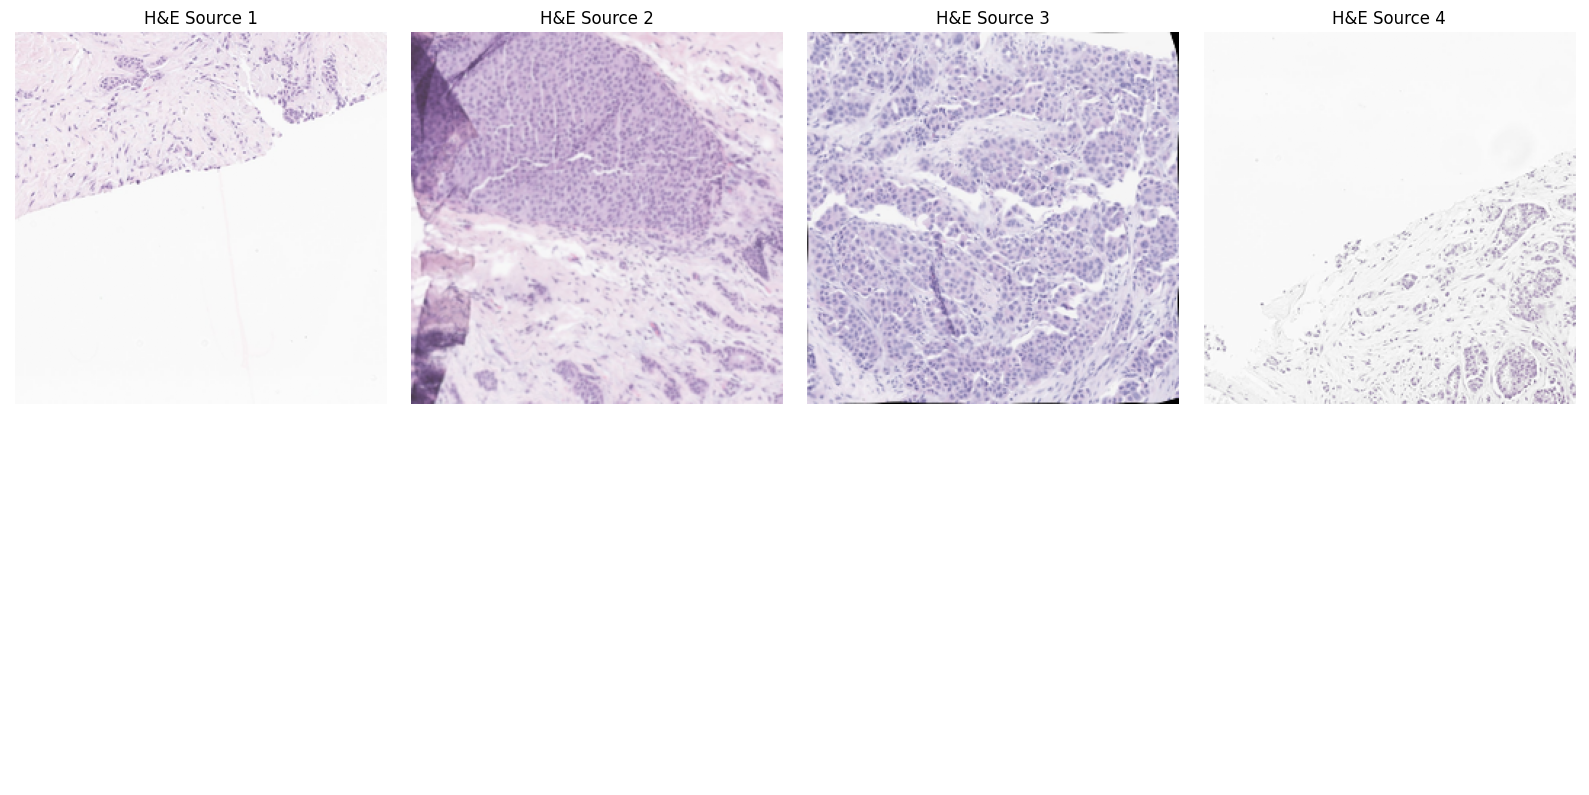

In [6]:
# Visualize sample batch
import matplotlib.pyplot as plt

batch = next(iter(train_loader))
print(f"Batch keys: {batch.keys()}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    # H&E source
    src = (batch['source'][i].permute(1, 2, 0).numpy() + 1) / 2
    axes[0, i].imshow(src)
    axes[0, i].set_title(f"H&E Source {i+1}")
    axes[0, i].axis('off')
    
    # IHC target
    if 'target' in batch:
        tgt = (batch['target'][i].permute(1, 2, 0).numpy() + 1) / 2
        domain = ['ER', 'PR', 'Ki67', 'Her2'][batch['target_domain'][i]]
        axes[1, i].imshow(tgt)
        axes[1, i].set_title(f"IHC {domain}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('sample_batch.png', dpi=150)
plt.show()

## 5. Initialize Training

In [7]:
from trainers.trainer import Trainer

trainer = Trainer(
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
)


Model Parameters:
  Generator:       82,028,611
  Discriminator:   20,874,063
  Style Encoder:   11,725,312
  Mapping Network: 1,190,656
  Total:           115,818,642
Mixed Precision: True
Gradient Accumulation: 1
EMA: True



## 6. Start Training

**Estimated time: 60-84 hours for 300 epochs**

In [8]:
# Start training
trainer.train(CONFIG['training']['epochs'])

Starting training for 100 epochs...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([32, 3, 256, 256])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

poch 0:   0%|          | 0/43 [00:03<?, ?it/s]

RuntimeError: The size of tensor a (64) must match the size of tensor b (256) at non-singleton dimension 3

## 7. Monitor Training

Open TensorBoard in another terminal:
```bash
tensorboard --logdir=./logs --port=6006
```

In [ ]:
# Launch TensorBoard inline (optional)
%load_ext tensorboard
%tensorboard --logdir ./logs

## 8. Resume Training (if interrupted)

In [ ]:
# Resume from checkpoint
CHECKPOINT_PATH = "./checkpoints/epoch_50.pth"  # Update as needed

trainer = Trainer(
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    resume_from=CHECKPOINT_PATH,
)

trainer.train(CONFIG['training']['epochs'])

## 9. Test Inference

In [ ]:
import torch
from PIL import Image
import numpy as np

# Load trained model
checkpoint = torch.load('./checkpoints/final.pth')

from models import Generator, MappingNetwork, StyleEncoder

generator = Generator(
    image_size=256,
    style_dim=64,
    **CONFIG['model']['generator']
    ).cuda()

style_encoder = StyleEncoder(
    image_size=256,
    style_dim=CONFIG['model']['style_dim'],
    num_domains=CONFIG['model']['num_domains'],
    **CONFIG['model']['style_encoder']
    ).cuda()

generator.load_state_dict(checkpoint['generator'])
style_encoder.load_state_dict(checkpoint['style_encoder'])

# Apply EMA weights if present
if 'ema_shadow' in checkpoint:
    shadow = checkpoint['ema_shadow']
    for name, param in generator.named_parameters():
        if name in shadow:
            param.data.copy_(shadow[name])

generator.eval()
style_encoder.eval()

print("Model loaded!")

In [ ]:
# Generate paired virtual stain (reference-guided)
import matplotlib.pyplot as plt

# Get a test sample
test_batch = next(iter(val_loader))
source = test_batch['source'][:1].cuda()
reference = test_batch.get('target', test_batch['reference'])[:1].cuda()
domain_idx = test_batch['target_domain'][:1].cuda()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Show source
src_img = (source[0].permute(1, 2, 0).cpu().numpy() + 1) / 2
axes[0].imshow(src_img)
axes[0].set_title('H&E Input')
axes[0].axis('off')

# Show paired target if available
if 'target' in test_batch:
    tgt_img = (test_batch['target'][0].permute(1, 2, 0).cpu().numpy() + 1) / 2
    axes[1].imshow(tgt_img)
    axes[1].set_title('IHC Target')
else:
    axes[1].imshow(src_img)
    axes[1].set_title('Target (missing)')
axes[1].axis('off')

# Generate output using paired reference style
with torch.no_grad():
    style = style_encoder(reference, domain_idx)
    output = generator(source, style)

out_img = (output[0].permute(1, 2, 0).cpu().numpy() + 1) / 2
axes[2].imshow(out_img)
axes[2].set_title('Generated (paired style)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('inference_results.png', dpi=150)
plt.show()

## 10. Download Results

After training, download:
- `./checkpoints/final.pth` - Trained model
- `./samples/` - Training samples
- `./logs/` - TensorBoard logs

In [ ]:
# Create zip of results
import shutil
shutil.make_archive('training_results', 'zip', '.', 'checkpoints')
print("Created training_results.zip - download this file!")